# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
from sklearn.svm import SVC
from scipy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from array import array
from os.path  import join

# Make custom dataloader to load dataset

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

# 1. Load dataset

In [3]:
input_path = './dataset'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


# Show sample image

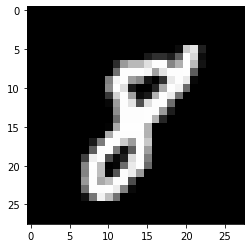

In [4]:
%matplotlib inline
random_idx=np.random.randint(100)
plt.imshow(x_train[random_idx], cmap = 'gray')
plt.show()

# 2. Describe steps for PCA
1. First, scale the given data to same range (normalize data, mean  =0, variance = 1) You should fit the test data using train scale!
2. Calculate covariance matrix, our dataset(28x28) should be converted to 1x28^2 array for calculation
3. Using eigenvalue and eigenvector, get eigenvectors that having largest eigenvalue(maybe top n)
4. Project normalized x to eigenvector

# 3. Write a pseudo-code for 2
standardScaler = StandardScaler.fit(x_train) 
norm_x_train = standardScaler.transform(x_train)  
Caluculate covaraince matrix cov by calculating np.matmul(norm_x_train.T, norm_x_train)  
Find eigenvalue and eigenvector, and choose how many vector to use  
(I personally prefer <5% data loss, which can be calculated by eig_w[0] / sum(eig_w))
proj_x_train = np.matmul(eig_vectors, norm_x_train.T)
end

# 4. Using the results from problem 1 to 3, construct a code that distinguishes 10 classes from 0 to 9 from a given dataset (MNIST) using PCA, so-called hand-writing recognition.

# Scale given data(normalize)

In [5]:
standardScaler = StandardScaler().fit(x_train.reshape(-1,28*28))
norm_x_train = standardScaler.transform(x_train.reshape(-1,28*28))
print(np.mean(norm_x_train), np.var(norm_x_train), np.shape(norm_x_train))

-2.1974863349995617e-18 0.9145408163265558 (60000, 784)


# Calculate covariance matrix

In [6]:
cov_mat = np.matmul(norm_x_train.T, norm_x_train)
print(np.shape(cov_mat))

(784, 784)


# Find how many need for dataloss = 5%, It seems use top 10(774~) is reasonable

In [7]:
idx = 782
data_loss = 1
while(data_loss > 0.05):
    eig_w, eig_v = eigh(cov_mat, eigvals=(idx, 783))
    data_loss = eig_w[0] / np.sum(eig_w)
    print("idx : " + str(idx) + ", data_loss = " + str(data_loss))
    idx -= 1

idx : 782, data_loss = 0.41936006580180335
idx : 781, data_loss = 0.2777241421411718
idx : 780, data_loss = 0.17646519086822218
idx : 779, data_loss = 0.13359986367311344
idx : 778, data_loss = 0.10416730405904916
idx : 777, data_loss = 0.08366656754082634
idx : 776, data_loss = 0.0705829537498866
idx : 775, data_loss = 0.05843718975664753
idx : 774, data_loss = 0.050656962405056676
idx : 773, data_loss = 0.04624696887980538


In [8]:
eig_w, eig_v = eigh(cov_mat, eigvals=(774, 783))
data_loss = eig_w[0] / np.sum(eig_w)
print(data_loss, np.shape(eig_v))

0.050656962405056676 (784, 10)


# Project train data to eigenvector

In [9]:
proj_x_train = np.matmul(norm_x_train, eig_v)
print(np.shape(proj_x_train))

(60000, 10)


# Here, I will use simple SVM for classification

In [10]:
clf = SVC()
clf.fit(proj_x_train, y_train)

SVC()

# Normalize and project test data to eigenvector

In [12]:
norm_x_test = standardScaler.transform(x_test.reshape(-1,28*28))
print(np.mean(norm_x_test), np.var(norm_x_test), np.shape(norm_x_test))
proj_x_test = np.matmul(norm_x_test, eig_v)
print(np.shape(proj_x_test))

0.002495697308915079 0.9161267079815967 (10000, 784)
(10000, 10)


# Show accuracy

In [21]:
train_correct = np.sum(clf.predict(proj_x_train) == y_train)
test_correct = np.sum(clf.predict(proj_x_test) == y_test)
train_accuracy = train_correct / np.shape(y_train)[0]
test_accuracy = test_correct / np.shape(y_test)[0]
print("train accuracy : " + str(train_accuracy))
print("test accuracy : " + str(test_accuracy))

train accuracy : 0.9313166666666667
test accuracy : 0.9265


# Quite good result :) Thank you for reading and Have a good day